In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import gc
import warnings
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
# CONFIGURATIONS
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Import datasets
dataset = pd.read_csv("final_dataset.csv")
print(dataset.head())
dataset = dataset.drop(dataset[(dataset['month'] == 1) & (dataset['day_of_month'] == 1)].index)

         date  store_nbr  daily_sales  daily_transactions  daily_onpromotion  \
0  2013-01-01         25      2511.62                 770               0.00   
1  2013-01-02          1      7417.15                2111               0.00   
2  2013-01-02          2     10266.72                2358               0.00   
3  2013-01-02          3     24060.35                3487               0.00   
4  2013-01-02          4     10200.08                1922               0.00   

   dcoilwtico_interpolated  day_of_week  day_of_month  month  year  \
0                    93.14            2             1      1  2013   
1                    93.14            3             2      1  2013   
2                    93.14            3             2      1  2013   
3                    93.14            3             2      1  2013   
4                    93.14            3             2      1  2013   

   is_national_holidays  is_regional_holidays  is_local_holidays  
0                     1        

In [13]:
# Normalize the data
selected_columns = ['daily_sales', 'daily_transactions', 'daily_onpromotion', 'dcoilwtico_interpolated']
dataset_selected = dataset[selected_columns]
daily_sales_mean = dataset['daily_sales'].mean()
daily_sales_std = dataset['daily_sales'].std()
normalized_dataset = (dataset_selected - dataset_selected.mean()) / dataset_selected.std()
dataset[selected_columns] = normalized_dataset
dataset['year'] = dataset['year'] - 2012

# Split the data
train = dataset.iloc[:65129]
test = dataset.iloc[65129:]

In [30]:
def make_store_prediction_LSTM(store_nb, lmst_nb):
  # Prepare the data
  train_data = train[train['store_nbr'] == store_nb]
  train_data = train_data.drop('store_nbr', axis=1)
  date_train = pd.to_datetime(train_data['date']) # usefull the the date on the plot axis
  train_data = train_data.drop("date", axis=1)
  train_data.reset_index(drop=True, inplace=True)
  test_data = test[test['store_nbr'] == store_nb]
  test_data = test_data.drop('store_nbr', axis=1)
  date_test = pd.to_datetime(test_data['date']) # usefull the the date on the plot axis
  test_data = test_data.drop("date", axis=1)
  test_data.reset_index(drop=True, inplace=True)

  # Create the X_train, X_test, Y_train and Y_test variables
  X_str_train = train_data.drop('daily_sales', axis=1)
  Y_str_train = train_data['daily_sales']
  X_str_test = test_data.drop('daily_sales', axis=1)
  Y_str_test = test_data['daily_sales']

  # Reshape the variables for the LSTM model
  X_str_train = X_str_train.to_numpy()
  X_str_train = X_str_train.reshape((X_str_train.shape[0], 1, X_str_train.shape[1]))
  X_str_test = X_str_test.to_numpy()
  X_str_test = X_str_test.reshape((X_str_test.shape[0], 1, X_str_test.shape[1]))

  # Construction of the LSTM NN
  model2 = Sequential()
  model2.add(LSTM(lmst_nb, input_shape=(X_str_train.shape[1], X_str_train.shape[2])))
  model2.add(Dense(1))
  model2.compile(optimizer='adam', loss='mean_squared_error')
  model2.fit(X_str_train, Y_str_train, epochs=20, batch_size=31, validation_data=(X_str_test, Y_str_test))
  #model2.fit(X_str_train, Y_str_train, epochs=20, batch_size=32, validation_split=(X_str_train, Y_str_train))

  # Model evaluation
  loss2 = model2.evaluate(X_str_test, Y_str_test)
  print(f'Loss (Mean Squared Error) sur l\'ensemble de test : {loss2}')

  # Prediction on training and test sets
  Y_train_predict = model2.predict(X_str_train)
  Y_test_predict = model2.predict(X_str_test)

  # calculate root mean squared error
  train_rmse = math.sqrt(mean_squared_error(Y_str_train, Y_train_predict[:,0]))
  print('Train Score: %.2f RMSE' % (train_rmse))
  test_rmse = math.sqrt(mean_squared_error(Y_str_test, Y_test_predict[:,0]))
  print('Test Score: %.2f RMSE' % (test_rmse))

  # Calculate R2
  train_r2 = r2_score(Y_str_train, Y_train_predict)
  print('Train Score: %.2f R2' % (train_r2))
  test_r2 = r2_score(Y_str_test, Y_test_predict)
  print('Test Score: %.2f R2' % (test_r2))

  # Calculate the RMSE and R² std
  rmse_std = np.std([train_rmse, test_rmse])
  r2_std = np.std([train_r2, test_r2])
  print(f'Standard Deviation of RMSE: {rmse_std:.2f}')
  print(f'Standard Deviation of R2: {r2_std:.2f}')

  # Find non-standardized daily_sales
  Y_str_train = (Y_str_train * daily_sales_std) + daily_sales_mean
  Y_str_test = (Y_str_test * daily_sales_std) + daily_sales_mean
  Y_train_predict[:,0] = (Y_train_predict[:,0] * daily_sales_std) + daily_sales_mean
  Y_test_predict[:,0] = (Y_test_predict[:,0] * daily_sales_std) + daily_sales_mean

  # Plot for training set
  plt.subplot(2, 1, 1)
  plt.plot(date_train, Y_str_train, label='Real values (Y_train)')
  plt.plot(date_train, Y_train_predict, label='Predicted values (Y_train_predict)')
  plt.title(f'Comparison between LSTM predicted/real values on the train for the store {store_nb}')
  plt.legend()

  # Plot for testing set
  plt.subplot(2, 1, 2)
  plt.plot(date_test, Y_str_test, label='Real values (Y_test)')
  plt.plot(date_test, Y_test_predict, label='Predicted values (Y_test_predict)')
  plt.title(f'Comparison between LSTM predicted/real values on the test for the store {store_nb}')
  plt.legend()

  # Plot pour l'ensemble d'entraînement et de test sur un unique graphique
  #plt.plot(date_train, Y_str_train, label='Real values (Train)', color='blue')
  #plt.plot(date_train, Y_train_predict, label='Predicted values (Train & Test)', color='orange')
  #plt.plot(date_test, Y_test_predict, color='orange')
  #plt.title(f'Comparison between predicted/real values on the train and test for the store {store_nb}')
  #plt.xlabel('Month and Year')
  #plt.legend()

  plt.tight_layout()
  plt.show()

In [29]:
def make_store_prediction_RNN(store_nb, lmst_nb):
  # Prepare the data
  train_data = train[train['store_nbr'] == store_nb]
  train_data = train_data.drop('store_nbr', axis=1)
  date_train = pd.to_datetime(train_data['date']) # usefull the the date on the plot axis
  train_data = train_data.drop("date", axis=1)
  train_data.reset_index(drop=True, inplace=True)
  test_data = test[test['store_nbr'] == store_nb]
  test_data = test_data.drop('store_nbr', axis=1)
  date_test = pd.to_datetime(test_data['date']) # usefull the the date on the plot axis
  test_data = test_data.drop("date", axis=1)
  test_data.reset_index(drop=True, inplace=True)

  # Create the X_train, X_test, Y_train and Y_test variables
  X_str_train = train_data.drop('daily_sales', axis=1)
  Y_str_train = train_data['daily_sales']
  X_str_test = test_data.drop('daily_sales', axis=1)
  Y_str_test = test_data['daily_sales']

  # Reshape the variables for the Simple RNN model
  X_str_train = X_str_train.to_numpy()
  X_str_train = X_str_train.reshape((X_str_train.shape[0], 1, X_str_train.shape[1]))
  X_str_test = X_str_test.to_numpy()
  X_str_test = X_str_test.reshape((X_str_test.shape[0], 1, X_str_test.shape[1]))

  # Construction of the SimpleRNN NN
  model2 = Sequential()
  model2.add(SimpleRNN(lmst_nb, input_shape=(X_str_train.shape[1], X_str_train.shape[2])))
  model2.add(Dense(1))
  model2.compile(optimizer='adam', loss='mean_squared_error')
  model2.fit(X_str_train, Y_str_train, epochs=20, batch_size=31, validation_data=(X_str_test, Y_str_test))

  # Model evaluation
  loss2 = model2.evaluate(X_str_test, Y_str_test)
  print(f'Loss (Mean Squared Error) sur l\'ensemble de test : {loss2}')

  # Prediction on training and test sets
  Y_train_predict = model2.predict(X_str_train)
  Y_test_predict = model2.predict(X_str_test)

  # calculate root mean squared error
  train_rmse = math.sqrt(mean_squared_error(Y_str_train, Y_train_predict[:,0]))
  print('Train Score: %.2f RMSE' % (train_rmse))
  test_rmse = math.sqrt(mean_squared_error(Y_str_test, Y_test_predict[:,0]))
  print('Test Score: %.2f RMSE' % (test_rmse))

  # Calculate R2
  train_r2 = r2_score(Y_str_train, Y_train_predict)
  print('Train Score: %.2f R2' % (train_r2))
  test_r2 = r2_score(Y_str_test, Y_test_predict)
  print('Test Score: %.2f R2' % (test_r2))

  # Calculate the RMSE and R² std
  rmse_std = np.std([train_rmse, test_rmse])
  r2_std = np.std([train_r2, test_r2])
  print(f'Standard Deviation of RMSE: {rmse_std:.2f}')
  print(f'Standard Deviation of R2: {r2_std:.2f}')

  # Find non-standardized daily_sales
  Y_str_train = (Y_str_train * daily_sales_std) + daily_sales_mean
  Y_str_test = (Y_str_test * daily_sales_std) + daily_sales_mean
  Y_train_predict[:,0] = (Y_train_predict[:,0] * daily_sales_std) + daily_sales_mean
  Y_test_predict[:,0] = (Y_test_predict[:,0] * daily_sales_std) + daily_sales_mean

  # Plot for training set
  plt.subplot(2, 1, 1)
  plt.plot(date_train, Y_str_train, label='Real values (Y_train)')
  plt.plot(date_train, Y_train_predict, label='Predicted values (Y_train_predict)')
  plt.title(f'Comparison between Simple RNN predicted/real values on the train for the store {store_nb}')
  plt.legend()

  # Plot for testing set
  plt.subplot(2, 1, 2)
  plt.plot(date_test, Y_str_test, label='Real values (Y_test)')
  plt.plot(date_test, Y_test_predict, label='Predicted values (Y_test_predict)')
  plt.title(f'Comparison between Simple RNN predicted/real values on the test for the store {store_nb}')
  plt.legend()

  # Plot pour l'ensemble d'entraînement et de test sur un unique graphique
  #plt.plot(date_train, Y_str_train, label='Real values (Train)', color='blue')
  #plt.plot(date_train, Y_train_predict, label='Predicted values (Train & Test)', color='orange')
  #plt.plot(date_test, Y_test_predict, color='orange')
  #plt.title(f'Comparison between predicted/real values on the train and test for the store {store_nb}')
  #plt.xlabel('Month and Year')
  #plt.legend()

  plt.tight_layout()
  plt.show()

In [28]:
def make_store_prediction_GRU(store_nb, lmst_nb):
  # Prepare the data
  train_data = train[train['store_nbr'] == store_nb]
  train_data = train_data.drop('store_nbr', axis=1)
  date_train = pd.to_datetime(train_data['date']) # usefull the the date on the plot axis
  train_data = train_data.drop("date", axis=1)
  train_data.reset_index(drop=True, inplace=True)
  test_data = test[test['store_nbr'] == store_nb]
  test_data = test_data.drop('store_nbr', axis=1)
  date_test = pd.to_datetime(test_data['date']) # usefull the the date on the plot axis
  test_data = test_data.drop("date", axis=1)
  test_data.reset_index(drop=True, inplace=True)

  # Create the X_train, X_test, Y_train and Y_test variables
  X_str_train = train_data.drop('daily_sales', axis=1)
  Y_str_train = train_data['daily_sales']
  X_str_test = test_data.drop('daily_sales', axis=1)
  Y_str_test = test_data['daily_sales']

  # Reshape the variables for the GRU model
  X_str_train = X_str_train.to_numpy()
  X_str_train = X_str_train.reshape((X_str_train.shape[0], 1, X_str_train.shape[1]))
  X_str_test = X_str_test.to_numpy()
  X_str_test = X_str_test.reshape((X_str_test.shape[0], 1, X_str_test.shape[1]))

  # Construction of the GRU NN
  model2 = Sequential()
  model2.add(GRU(lmst_nb, input_shape=(X_str_train.shape[1], X_str_train.shape[2])))
  model2.add(Dense(1))
  model2.compile(optimizer='adam', loss='mean_squared_error')
  model2.fit(X_str_train, Y_str_train, epochs=20, batch_size=31, validation_data=(X_str_test, Y_str_test))

  # Model evaluation
  loss2 = model2.evaluate(X_str_test, Y_str_test)
  print(f'Loss (Mean Squared Error) sur l\'ensemble de test : {loss2}')

  # Prediction on training and test sets
  Y_train_predict = model2.predict(X_str_train)
  Y_test_predict = model2.predict(X_str_test)

  # calculate root mean squared error
  train_rmse = math.sqrt(mean_squared_error(Y_str_train, Y_train_predict[:,0]))
  print('Train Score: %.2f RMSE' % (train_rmse))
  test_rmse = math.sqrt(mean_squared_error(Y_str_test, Y_test_predict[:,0]))
  print('Test Score: %.2f RMSE' % (test_rmse))

  # Calculate R2
  train_r2 = r2_score(Y_str_train, Y_train_predict)
  print('Train Score: %.2f R2' % (train_r2))
  test_r2 = r2_score(Y_str_test, Y_test_predict)
  print('Test Score: %.2f R2' % (test_r2))

  # Calculate the RMSE and R² std
  rmse_std = np.std([train_rmse, test_rmse])
  r2_std = np.std([train_r2, test_r2])
  print(f'Standard Deviation of RMSE: {rmse_std:.2f}')
  print(f'Standard Deviation of R2: {r2_std:.2f}')

  # Find non-standardized daily_sales
  Y_str_train = (Y_str_train * daily_sales_std) + daily_sales_mean
  Y_str_test = (Y_str_test * daily_sales_std) + daily_sales_mean
  Y_train_predict[:,0] = (Y_train_predict[:,0] * daily_sales_std) + daily_sales_mean
  Y_test_predict[:,0] = (Y_test_predict[:,0] * daily_sales_std) + daily_sales_mean

  # Plot for training set
  plt.subplot(2, 1, 1)
  plt.plot(date_train, Y_str_train, label='Real values (Y_train)')
  plt.plot(date_train, Y_train_predict, label='Predicted values (Y_train_predict)')
  plt.title(f'Comparison between GRU predicted/real values on the train for the store {store_nb}')
  plt.legend()

  # Plot for testing set
  plt.subplot(2, 1, 2)
  plt.plot(date_test, Y_str_test, label='Real values (Y_test)')
  plt.plot(date_test, Y_test_predict, label='Predicted values (Y_test_predict)')
  plt.title(f'Comparison between GRU predicted/real values on the test for the store {store_nb}')
  plt.legend()

  # Plot pour l'ensemble d'entraînement et de test sur un unique graphique
  #plt.plot(date_train, Y_str_train, label='Real values (Train)', color='blue')
  #plt.plot(date_train, Y_train_predict, label='Predicted values (Train & Test)', color='orange')
  #plt.plot(date_test, Y_test_predict, color='orange')
  #plt.title(f'Comparison between predicted/real values on the train and test for the store {store_nb}')
  #plt.xlabel('Month and Year')
  #plt.legend()

  plt.tight_layout()
  plt.show()

Epoch 1/20
43/43 [==============================] - 2s 10ms/step - loss: 0.3200 - val_loss: 0.4129
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1942 - val_loss: 0.3659
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1651 - val_loss: 0.3145
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1395 - val_loss: 0.2768
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1186 - val_loss: 0.2276
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.2047
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0902 - val_loss: 0.1802
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.1548
Epoch 9/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.1262
Epoch 10/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0959
Epoch 11/20
43/43 

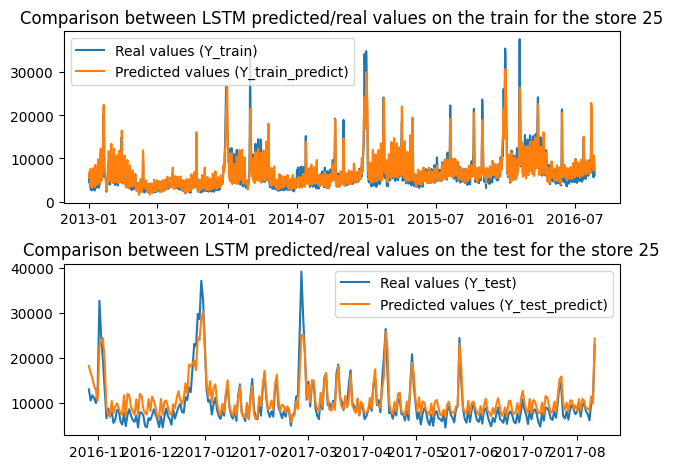

In [31]:
# Make daily sales predictions for the store of your choice and the number of LSTM neurons of your choice

make_store_prediction_LSTM(25, 20)

Epoch 1/20
43/43 [==============================] - 2s 6ms/step - loss: 1.4991 - val_loss: 0.8825
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.5498 - val_loss: 0.6073
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.3189 - val_loss: 0.4727
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.2357 - val_loss: 0.4201
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.2023 - val_loss: 0.3873
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1732 - val_loss: 0.3208
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1546 - val_loss: 0.2968
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1432 - val_loss: 0.2797
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1333 - val_loss: 0.2621
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1247 - val_loss: 0.2483
Epoch 11/20
43/43 [

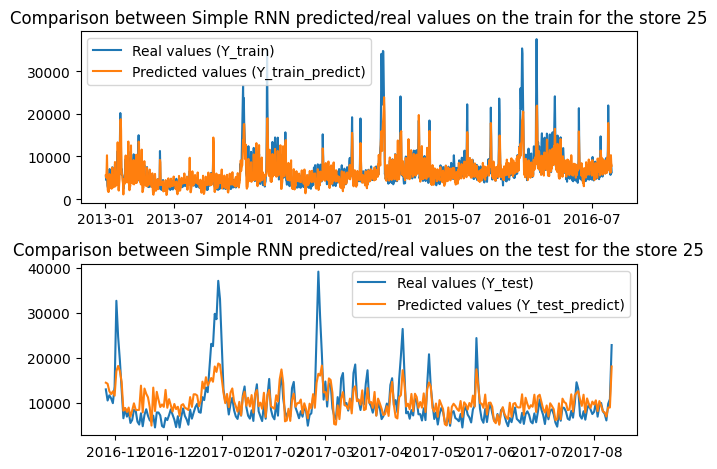

In [32]:
# Make daily sales predictions for the store of your choice and the number of Simple RNN neurons of your choice

make_store_prediction_RNN(25, 20)

Epoch 1/20
43/43 [==============================] - 2s 10ms/step - loss: 0.4861 - val_loss: 0.4208
Epoch 2/20
43/43 [==============================] - 0s 3ms/step - loss: 0.2182 - val_loss: 0.3471
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1697 - val_loss: 0.2974
Epoch 4/20
43/43 [==============================] - 0s 3ms/step - loss: 0.1343 - val_loss: 0.2696
Epoch 5/20
43/43 [==============================] - 0s 3ms/step - loss: 0.1195 - val_loss: 0.2451
Epoch 6/20
43/43 [==============================] - 0s 3ms/step - loss: 0.1077 - val_loss: 0.2249
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0972 - val_loss: 0.2090
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.1936
Epoch 9/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0813 - val_loss: 0.1801
Epoch 10/20
43/43 [==============================] - 0s 3ms/step - loss: 0.0721 - val_loss: 0.1616
Epoch 11/20
43/43 

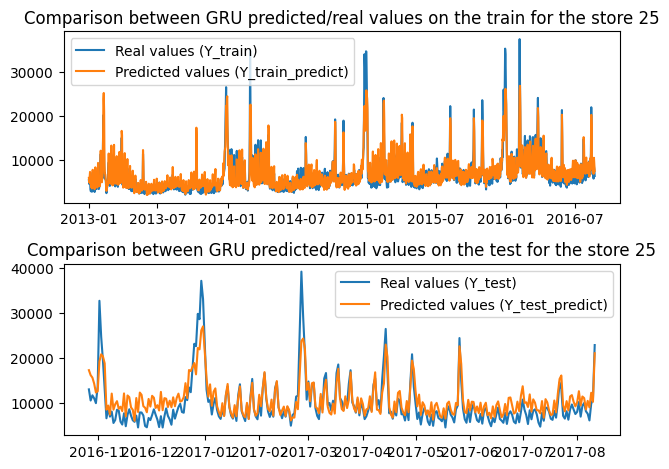

In [33]:
# Make daily sales predictions for the store of your choice and the number of GRU neurons of your choice

make_store_prediction_GRU(25, 20)

In [20]:
#Daily sales

# Grouper par 'year', 'month', 'day_of_month' et appliquer sum sur 'daily_transactions' et prod sur 'oil'
X_train_sum = X_train.groupby(['year', 'month', 'day_of_month']).agg({
    'daily_transactions': 'sum',    # Somme des 'daily_transactions'
    'is_national_holidays': np.prod,                 # Produit des valeurs de 'holiday' pour garder le coté binaire
}).reset_index()

X_test_sum = X_test.groupby(['year', 'month', 'day_of_month']).agg({
    'daily_transactions': 'sum',    # Somme des 'daily_transactions'
    'is_national_holidays': np.prod,                 # Produit des valeurs de 'holiday' pour garder le coté binaire
}).reset_index()

Y_train_sum = (train_1.groupby(['year', 'month', 'day_of_month'])['daily_sales'].sum().reset_index())['daily_sales']
Y_test_sum = (test_1.groupby(['year', 'month', 'day_of_month'])['daily_sales'].sum().reset_index())['daily_sales']

#print(Y_train_sum)
#print(X_train_sum)
#print(X_test_sum)

# Remodeler les données pour les rendre compatibles avec l'entrée LSTM (3D) pour la somme
X_train_sum = X_train_sum.to_numpy().reshape((X_train_sum.shape[0], 1, X_train_sum.shape[1]))
X_test_sum = X_test_sum.to_numpy().reshape((X_test_sum.shape[0], 1, X_test_sum.shape[1]))

NameError: ignored

In [ ]:
# Plot pour l'ensemble d'entraînement
plt.subplot(2, 1, 1)
plt.plot(Y_train, label='Vraies valeurs (Y_train)')
plt.plot(Y_train_predict, label='Prédictions (Y_train_predict)')
plt.title('Comparaison des prédictions sur l\'ensemble d\'entraînement')
plt.legend()

# Plot pour l'ensemble de test
plt.subplot(2, 1, 2)
plt.plot(Y_test, label='Vraies valeurs (Y_test)')
plt.plot(Y_test_predict, label='Prédictions (Y_test_predict)')
plt.title('Comparaison des prédictions sur l\'ensemble de test')
plt.legend()

plt.tight_layout()
plt.show()